# Part 4: Advanced Data Augmentation for Audio Classification

In our previous notebook, we confirmed that data augmentation is a highly effective strategy for improving our model's performance and reducing overfitting. We saw a significant jump in accuracy and a much more balanced model when we expanded our training set with simple augmentations.

This notebook will take that concept a step further. We will implement a more advanced and robust augmentation pipeline:

1.  **Introduce a New Augmentation:** We will add **time shifting** to our set of tools. This simulates the sound starting at a slightly different time.
2.  **Randomized Augmentation:** Instead of creating a fixed set of augmentations for each audio clip (e.g., one with noise, one with a pitch shift), we will create multiple augmented versions where each version has a **randomly chosen augmentation** applied. This creates a much more diverse and less predictable training set, which is a very powerful technique for forcing the model to learn the core features of the sound.
3.  **Train and Evaluate:** We will then train a new binary CNN on this more richly augmented dataset and compare its performance to our previous models.


## 1. Setup and Imports


In [1]:
# This cell will install libraries if they are not already present.
%pip install tensorflow scikit-learn librosa numpy pandas matplotlib seaborn tqdm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\fe_de\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

sns.set_theme(style="whitegrid")


C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

## 2. Data Preparation and Advanced Augmentation

Here we define our functions and constants. We add `time_shift` to our augmentation toolkit. We will then split our file paths before doing any processing to ensure a clean separation between training and validation data.


In [3]:
# --- Parameters ---
BASE_AUDIO_PATH = 'Audios para Treinamento/'
FIXED_DURATION_S = 10
SAMPLE_RATE = 22050
FIXED_LENGTH = SAMPLE_RATE * FIXED_DURATION_S

# --- Augmentation Functions ---
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

def time_stretch(audio, stretch_rate=0.8):
    return librosa.effects.time_stretch(y=audio, rate=stretch_rate)

def pitch_shift(audio, sample_rate, n_steps=4):
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=n_steps)

def time_shift(audio, shift_max_percent=0.2):
    shift = int(len(audio) * shift_max_percent * random.uniform(-1, 1))
    return np.roll(audio, shift)

# --- Get all file paths and their binary labels ---
classes = os.listdir(BASE_AUDIO_PATH)
all_files = []
all_binary_labels = []

for label in classes:
    class_path = os.path.join(BASE_AUDIO_PATH, label)
    files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.wav')]
    all_files.extend(files)
    binary_label = 'NoLeak' if label.startswith('NoLeak') else 'Leak'
    all_binary_labels.extend([binary_label] * len(files))

# --- Split file paths into training and validation sets ---
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_binary_labels, test_size=0.2, random_state=42, stratify=all_binary_labels
)

print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")


Training files: 48
Validation files: 12


## 2.1 Process Audio with Randomized Augmentation


In [4]:
# This function will handle loading, padding/truncating, and converting to spectrogram
def process_audio(audio, sample_rate):
    if len(audio) < FIXED_LENGTH:
        audio = np.pad(audio, (0, FIXED_LENGTH - len(audio)), 'constant')
    else:
        audio = audio[:FIXED_LENGTH]
    
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
    return librosa.power_to_db(spectrogram, ref=np.max)

# --- Process training and validation sets ---
X_train_adv, y_train_adv = [], []
X_val_adv, y_val_adv = [], []
AUGMENTATIONS_PER_FILE = 4

# List of augmentation functions to choose from
augmentation_choices = [add_noise, time_stretch, pitch_shift, time_shift]

print("Processing and applying randomized augmentations to training data...")
for file, label in tqdm(zip(train_files, train_labels), total=len(train_files)):
    try:
        audio, sr = librosa.load(file, sr=SAMPLE_RATE)

        # 1. Add the original audio
        X_train_adv.append(process_audio(audio, sr))
        y_train_adv.append(label)

        # 2. Add augmented versions
        for _ in range(AUGMENTATIONS_PER_FILE):
            # Choose a random augmentation
            aug_func = random.choice(augmentation_choices)
            
            # Apply it
            if aug_func == pitch_shift: # pitch_shift needs sr
                augmented_audio = aug_func(audio, sample_rate=sr)
            else:
                augmented_audio = aug_func(audio)
            
            X_train_adv.append(process_audio(augmented_audio, sr))
            y_train_adv.append(label)

    except Exception as e:
        print(f"Error during augmentation for {file}: {e}")

print("\nProcessing validation data (no augmentation)...")
for file, label in tqdm(zip(val_files, val_labels), total=len(val_files)):
    try:
        audio, sr = librosa.load(file, sr=SAMPLE_RATE)
        spec = process_audio(audio, sr)
        X_val_adv.append(spec)
        y_val_adv.append(label)
    except Exception as e:
        print(f"Error processing validation file {file}: {e}")

# --- Prepare data for the model ---
X_train_adv = np.array(X_train_adv)[..., np.newaxis]
y_train_adv = np.array(y_train_adv)

X_val_adv = np.array(X_val_adv)[..., np.newaxis]
y_val_adv = np.array(y_val_adv)

# Encode labels
adv_label_encoder = LabelEncoder()
y_train_adv_enc = adv_label_encoder.fit_transform(y_train_adv)
y_val_adv_enc = adv_label_encoder.transform(y_val_adv)

print(f"\nNew advanced training set size: {X_train_adv.shape[0]} samples")
print(f"Validation set size: {X_val_adv.shape[0]} samples")


Processing and applying randomized augmentations to training data...


100%|██████████| 48/48 [00:08<00:00,  5.55it/s]



Processing validation data (no augmentation)...


100%|██████████| 12/12 [00:00<00:00, 133.92it/s]


New advanced training set size: 240 samples
Validation set size: 12 samples


## 3. Build, Train, and Evaluate the Final Model

We will now train our final model on the new dataset. The architecture is identical to the previous binary model, but it will now learn from a much larger and more diverse set of examples.


In [5]:
adv_model = Sequential([
    # Input shape needs to be determined from the final training data
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_adv.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

adv_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# More epochs are suitable for a larger, augmented dataset
EPOCHS_ADV = 75
BATCH_SIZE = 32

adv_history = adv_model.fit(X_train_adv, y_train_adv_enc,
                            epochs=EPOCHS_ADV,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_val_adv, y_val_adv_enc),
                            verbose=1)


Epoch 1/75


C:\Users\fe_de\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.4583 - loss: 74.4074 - val_accuracy: 0.7500 - val_loss: 0.6261
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6000 - loss: 0.7902 - val_accuracy: 0.6667 - val_loss: 0.6665
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7375 - loss: 0.5301 - val_accuracy: 0.6667 - val_loss: 1.0008
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.7125 - loss: 0.5329 - val_accuracy: 0.5000 - val_loss: 2.1479
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6792 - loss: 0.7738 - val_accuracy: 0.6667 - val_loss: 0.7906
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6875 - loss: 1.1070 - val_accuracy: 0.6667 - val_loss: 0.5747
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7333 - loss: 0.5854 - val_accuracy: 0.7500 - val_loss: 0.7034
Epoch 8/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7750 - loss: 0.4975 - val_accuracy: 0.6667 - val_loss: 0.7614
Ep

## 3.1 Final Evaluation


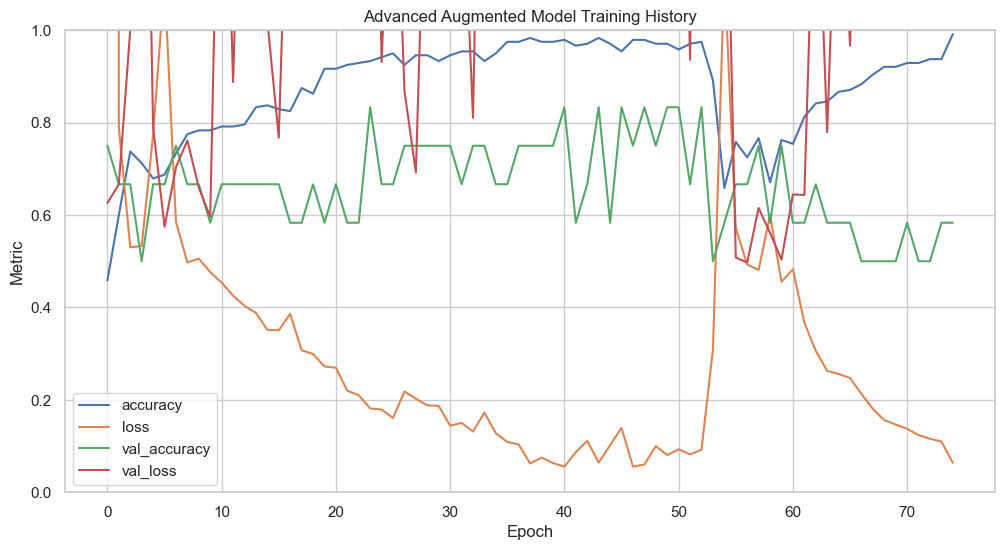

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
\nAdvanced Augmented Model Classification Report:\n
              precision    recall  f1-score   support

        Leak       0.57      0.67      0.62         6
      NoLeak       0.60      0.50      0.55         6

    accuracy                           0.58        12
   macro avg       0.59      0.58      0.58        12
weighted avg       0.59      0.58      0.58        12



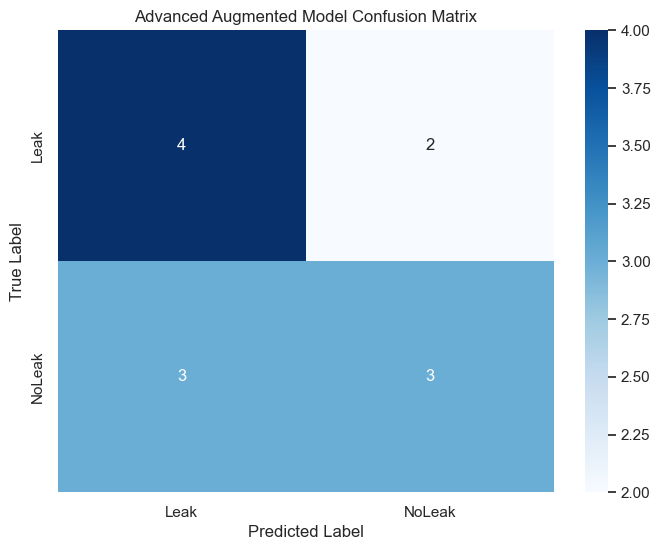

In [6]:
# Plotting training history for the advanced augmented model
pd.DataFrame(adv_history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('Advanced Augmented Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

# Make predictions
y_pred_probs_adv = adv_model.predict(X_val_adv)
y_pred_adv = (y_pred_probs_adv > 0.5).astype("int32").reshape(-1)

# Generate and print the classification report
print("\\nAdvanced Augmented Model Classification Report:\\n")
print(classification_report(y_val_adv_enc, y_pred_adv, target_names=adv_label_encoder.classes_))

# Generate and plot the confusion matrix
conf_matrix_adv = confusion_matrix(y_val_adv_enc, y_pred_adv)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adv, annot=True, fmt='d',
            xticklabels=adv_label_encoder.classes_,
            yticklabels=adv_label_encoder.classes_,
            cmap='Blues')
plt.title('Advanced Augmented Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
